In [ ]:
! wget https://halldweb.jlab.org/talks/ML_lunch/May2019/TRAIN/images.raw.gz
! wget https://halldweb.jlab.org/talks/ML_lunch/May2019/TRAIN/track_parms.csv

--2020-10-01 13:44:16--  https://halldweb.jlab.org/talks/ML_lunch/May2019/TRAIN/images.raw.gz
Resolving halldweb.jlab.org (halldweb.jlab.org)... 129.57.64.128
Connecting to halldweb.jlab.org (halldweb.jlab.org)|129.57.64.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31813265 (30M) [application/x-gzip]
Saving to: ‘images.raw.gz’

images.raw.gz       100%[===================>]  30.34M  7.39MB/s    in 4.1s    

2020-10-01 13:44:24 (7.39 MB/s) - ‘images.raw.gz’ saved [31813265/31813265]

--2020-10-01 13:44:24--  https://halldweb.jlab.org/talks/ML_lunch/May2019/TRAIN/track_parms.csv
Resolving halldweb.jlab.org (halldweb.jlab.org)... 129.57.64.128
Connecting to halldweb.jlab.org (halldweb.jlab.org)|129.57.64.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38940211 (37M) [text/csv]
Saving to: ‘track_parms.csv’

track_parms.csv     100%[===================>]  37.14M  8.76MB/s    in 4.7s    

2020-10-01 13:44:30 (7.88 MB/s) - ‘track_

In [ ]:
import os
import sys
import gzip
import pandas as pd
import numpy as np
import math

width  = 36
height = 100

# Open labels files so we can get number of samples and pass the
# data frames to the generators later
traindf = pd.read_csv('track_parms.csv')
STEP_SIZE_TRAIN = len(traindf)/32

#-----------------------------------------------------
# generate_arrays_from_file
#-----------------------------------------------------
# Create generator to read in images and labels
# (used for both training and validation samples)
def generate_arrays_from_file( labelsdf ):

	images_path = './images.raw.gz'
	print( 'generator created for: ' + images_path)

	batch_input           = []
	batch_labels_phi      = []
	batch_labels_z        = []
	idx = 0
	ibatch = 0
	while True:  # loop forever, re-reading images from same file
		with gzip.open(images_path) as f:
			while True: # loop over images in file
			
				# Read in one image
				bytes = f.read(width*height)
				if len(bytes) != (width*height): break # break into outer loop so we can re-open file
				data = np.frombuffer(bytes, dtype='B', count=width*height)
				pixels = np.reshape(data, [width, height, 1], order='F')
				pixels_norm = np.transpose(pixels.astype(np.float) / 255., axes=(1, 0, 2) )
				
				# Labels
				phi = labelsdf.phi[idx]
				z   = labelsdf.z[idx]
				idx += 1

				# Add to batch and check if it is time to yield
				batch_input.append( pixels_norm )
				batch_labels_phi.append( phi )
				batch_labels_z.append( z )
				if len(batch_input) == 32 :
					ibatch += 1
					
					# Since we are training multiple loss functions we must
					# pass the labels back as a dictionary whose keys match
					# the layer their corresponding values are being applied to.
					labels_dict = {
						'phi_output' :  np.array(batch_labels_phi ),
						'z_output'   :  np.array(batch_labels_z   ),		
					}
					
					yield ( np.array(batch_input), labels_dict )
					batch_input      = []
					batch_labels_phi = []
					batch_labels_z   = []

			idx = 0
			f.close()


#===============================================================================
# Create training generator

In [ ]:
import requests
import gzip
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow import keras

In [ ]:
def buildBranch(input,str1):
  x = keras.layers.Conv2D(32,(3,3),activation='relu')(input)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.MaxPool2D()(x)

  x = keras.layers.Conv2D(32,(3,3),activation='relu')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.MaxPool2D()(x)
  
  x = keras.layers.Dropout(0.25)(x)
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(1,activation="linear",name=str1)(x)
  return x

inputs = keras.Input(shape=(100, 36, 1))
branch_z = buildBranch(inputs,"z_output")
branch_phi = buildBranch(inputs,"phi_output")
model = keras.Model(inputs=inputs, outputs={"z_output":branch_z, "phi_output":branch_phi}, name="detector")
losses = {
    "z":"mse",
    "phi":"mse"
}
lossWeights = 1.0
opt = "adam"
model.compile(optimizer=opt, loss=losses, loss_weights=lossWeights, metrics=["mae"])
model.summary()

Model: "detector"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 36, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 98, 34, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 98, 34, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 98, 34, 32)   128         conv2d_2[0][0]                   
___________________________________________________________________________________________

In [ ]:
train_generator = generate_arrays_from_file(traindf)

In [ ]:
H = model.fit_generator(generator=train_generator,
                        steps_per_epoch=200,
                        epochs=25,
                        use_multiprocessing=False
)
model.save("model.keras",save_format="h5")

Instructions for updating:
Please use Model.fit, which supports generators.
generator created for: ./images.raw.gz
Epoch 1/25
200/200 [==============================] - 1s 7ms/step - loss: 2.6008 - phi_output_loss: 2.6008 - phi_output_mae: 1.2019 - z_output_mae: 4.5055
Epoch 2/25
200/200 [==============================] - 1s 7ms/step - loss: 0.8823 - phi_output_loss: 0.8823 - phi_output_mae: 0.7391 - z_output_mae: 4.4270
Epoch 3/25
200/200 [==============================] - 1s 7ms/step - loss: 0.5227 - phi_output_loss: 0.5227 - phi_output_mae: 0.5687 - z_output_mae: 4.4487
Epoch 4/25
200/200 [==============================] - 1s 7ms/step - loss: 0.3494 - phi_output_loss: 0.3494 - phi_output_mae: 0.4634 - z_output_mae: 4.4827
Epoch 5/25
200/200 [==============================] - 1s 7ms/step - loss: 0.2592 - phi_output_loss: 0.2592 - phi_output_mae: 0.3980 - z_output_mae: 4.4500
Epoch 6/25
200/200 [==============================] - 1s 7ms/step - loss: 0.1806 - phi_output_loss: 0.1806 - p

dict_keys(['loss', 'phi_output_loss', 'phi_output_mae', 'z_output_mae'])


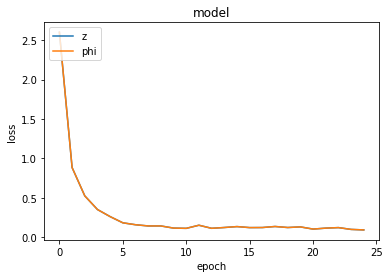

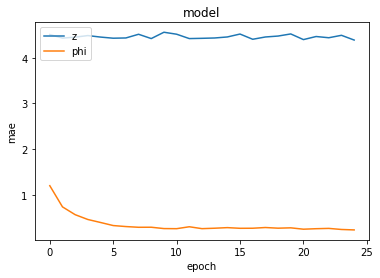

In [ ]:
print(H.history.keys())
try:
  plt.plot(H.history['loss'])
  plt.plot(H.history['phi_output_loss'])
  plt.title('model')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['z','phi'],loc='upper left')
  plt.show()
  plt.plot(H.history['z_output_mae'])
  plt.plot(H.history['phi_output_mae'])
  plt.title('model')
  plt.ylabel('mae')
  plt.xlabel('epoch')
  plt.legend(['z','phi'],loc='upper left')
  plt.show()
except e:
  print("error:")
  print(e)

### Seems like it doesn't learn well for the z value...



generator created for: ./images.raw.gz
100/100 [==============================] - 1s 6ms/step - loss: 0.0845 - phi_output_loss: 0.0845 - phi_output_mae: 0.2333 - z_output_mae: 4.3927
(32, 100, 36, 1)
{'phi_output': array([ 2.01213779, -4.39434358, -1.19735912,  3.00760576, -5.85278725,
        6.46863751, -3.60917171,  2.37215453,  6.83380298, -9.54461488,
       -9.32296813, -0.70031347, -3.67992828, -5.7734495 ,  1.65462479,
        7.9345067 ,  2.94476379, -9.39887459, -2.54422206,  9.49064753,
       -0.93451917, -4.84790649,  6.67486713,  7.54354584,  0.90785022,
        5.55145817, -3.79873593, -7.16952992,  2.45861179,  4.85348222,
       -2.57945959, -5.82820785]), 'z_output': array([ 3.19583565,  0.70618132, -7.19851558,  6.21130989,  5.21913547,
       -3.45651178, -0.11615041,  2.95434614, -1.52207262, -5.36276174,
       -3.65968532, -0.12459283, -2.3465705 ,  6.82702275,  1.84031584,
        4.11370385,  4.24321601,  3.47043357,  6.7092321 , -5.08201092,
        6.9085916 

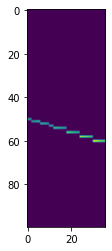

1/1 [==============================] - 0s 5ms/step
[1.8577756]  :  [2.01213779]  :  [-0.15436222]
[-3.859254]  :  [-4.39434358]  :  [0.5350897]
[-1.0647193]  :  [-1.19735912]  :  [0.1326398]
[2.8391538]  :  [3.00760576]  :  [-0.16845199]
[-5.305758]  :  [-5.85278725]  :  [0.54702925]
[6.36619]  :  [6.46863751]  :  [-0.10244755]
[-3.316372]  :  [-3.60917171]  :  [0.29279979]
[2.455346]  :  [2.37215453]  :  [0.08319158]
[6.842071]  :  [6.83380298]  :  [0.00826808]
[-9.366061]  :  [-9.54461488]  :  [0.17855367]
[-9.323065]  :  [-9.32296813]  :  [-9.66740771e-05]
[-0.4357373]  :  [-0.70031347]  :  [0.26457616]
[-3.2731485]  :  [-3.67992828]  :  [0.40677974]
[-5.1116076]  :  [-5.7734495]  :  [0.66184195]
[1.5957298]  :  [1.65462479]  :  [-0.05889496]
[7.8388567]  :  [7.9345067]  :  [-0.09565]
[2.9210835]  :  [2.94476379]  :  [-0.02368034]
[-9.175933]  :  [-9.39887459]  :  [0.22294171]
[-2.1405897]  :  [-2.54422206]  :  [0.40363235]
[9.680544]  :  [9.49064753]  :  [0.18989637]
[-0.7629736]  

In [ ]:
test_generator = generate_arrays_from_file(traindf)

ev = model.evaluate(test_generator,steps=100,batch_size=32)

test = next(test_generator)
test = np.array(test)
test_x = test[0]
test_y = test[1]
print(test_x.shape)
print(test_y)

plt.imshow(np.squeeze(test_x[0]))
plt.show()

pred = model.predict(x=test_x,verbose=1)
for i in range(25):
  print(pred["phi_output"][i]," : ",np.reshape(test_y["phi_output"],[32,1])[i]," : ",pred["phi_output"][i]-np.reshape(test_y["phi_output"],[32,1])[i])
for i in range(25):
  print(pred["z_output"][i]," : ",np.reshape(test_y["z_output"],[32,1])[i]," : ",pred["z_output"][i]-np.reshape(test_y["z_output"],[32,1])[i])

print(pred["phi_output"].shape," : ",np.reshape(test_y["phi_output"],[32,1]).shape)
